In [7]:
# 1. Install and Import
!pip install -q zarr gcsfs fsspec
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2. Configuration

STORE_URL = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/AGDC-feedstock/AGCD.zarr'
TARGET = 'precip'
VARS_X = ['tmax', 'tmin', 'vapourpres']
REGION = dict(lat=slice(-44.5, -10), lon=slice(112, 156.5))

# Model Settings
T_IN = 30           # Look back 30 days
COARSEN_LAT = 4
COARSEN_LON = 4
VARS_FOR_MODEL = VARS_X + ['doy_s', 'doy_c']
C_IN = len(VARS_FOR_MODEL)

# Training Settings
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

TRAIN_YEARS = ('1971', '2000')
VAL_YEARS   = ('2001', '2010')
TEST_YEARS  = ('2011', '2019')

In [4]:
# 3. Helper Functions

def open_agcd_engine_zarr(store):
    try: return xr.open_dataset(store, engine="zarr", chunks={})
    except: return xr.open_zarr(store, consolidated=True, chunks={})

def subset_years(ds, start, end, coarsen):
    ds = ds[VARS_X + [TARGET]].sel(**REGION).sel(time=slice(start, end))
    if coarsen > 1:
        ds = ds.coarsen(lat=coarsen, lon=coarsen, boundary="trim").mean()
    return ds.astype("float32")

def add_doy_channels(dsX):
    doy = dsX.time.dt.dayofyear.data
    return dsX.assign(doy_s=('time', np.sin(2*np.pi*doy/365.0)),
                      doy_c=('time', np.cos(2*np.pi*doy/365.0)))

def calculate_regional_averages(ds, vars_):
    weights = np.cos(np.deg2rad(ds.lat))
    weights = weights / weights.mean()
    avg_vars = []
    for var in vars_:
        if var in ['doy_s', 'doy_c']: avg_vars.append(ds[var])
        else: avg_vars.append(ds[var].weighted(weights).mean(dim=["lat", "lon"]))
    return xr.merge(avg_vars)

def grid_norm_stats_simple(X_train_avg):
    return X_train_avg.mean("time").compute(), (X_train_avg.std("time") + 1e-6).compute()

def apply_grid_norm_simple(dsX_avg, means, stds):
    return (dsX_avg - means) / stds

def y_fwd(da): return np.log1p(da)
def y_inv(a): return np.expm1(a)

def create_sequences(data_X, data_y, seq_length):
    xs, ys = [], []
    for i in range(len(data_X) - seq_length):
        x = data_X[i : i+seq_length]
        y = data_y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
# 4. Define LSTM

class MapLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_pixels):
        super(MapLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(hidden_size, output_pixels)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        return self.fc(last_out)

criterion = nn.MSELoss()

In [8]:
# 5. Main Model Script (Train/Val/Test Split)

print("Loading Data")
ds_all = open_agcd_engine_zarr(STORE_URL)

# Load three sets
ds_tr = add_doy_channels(subset_years(ds_all, *TRAIN_YEARS, COARSEN_LAT))
ds_val = add_doy_channels(subset_years(ds_all, *VAL_YEARS, COARSEN_LAT))
ds_te = add_doy_channels(subset_years(ds_all, *TEST_YEARS, COARSEN_LAT))

LAT_SIZE = ds_tr.lat.size
LON_SIZE = ds_tr.lon.size
N_PIXELS = LAT_SIZE * LON_SIZE

# 2. Prepare Input (X)
print("Calculating Regional Averages")
X_tr_avg = calculate_regional_averages(ds_tr, VARS_FOR_MODEL)
X_val_avg = calculate_regional_averages(ds_val, VARS_FOR_MODEL)
X_te_avg = calculate_regional_averages(ds_te, VARS_FOR_MODEL)

# Normalize (use Train stats)
means, stds = grid_norm_stats_simple(X_tr_avg)
X_tr_norm = apply_grid_norm_simple(X_tr_avg, means, stds)
X_val_norm = apply_grid_norm_simple(X_val_avg, means, stds)
X_te_norm = apply_grid_norm_simple(X_te_avg, means, stds)

# 3. Prepare Target (y)
print("Loading & Flattening Targets")
y_tr_flat = y_fwd(ds_tr[TARGET]).load().values.reshape(-1, N_PIXELS)
y_val_flat = y_fwd(ds_val[TARGET]).load().values.reshape(-1, N_PIXELS)
y_te_flat = y_fwd(ds_te[TARGET]).load().values.reshape(-1, N_PIXELS)

# 4. Create Sequences
print("Creating Sequences")
# Train
X_train_raw = X_tr_norm.to_dataframe().to_numpy().astype(np.float32)
X_train, y_train = create_sequences(X_train_raw, y_tr_flat, T_IN)

# Validation
X_val_raw = X_val_norm.to_dataframe().to_numpy().astype(np.float32)
X_val, y_val = create_sequences(X_val_raw, y_val_flat, T_IN)

# Test
X_test_raw = X_te_norm.to_dataframe().to_numpy().astype(np.float32)
X_test, y_test = create_sequences(X_test_raw, y_te_flat, T_IN)

# 5. DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
tr_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
te_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# 6. Train Loop
model = MapLSTM(input_size=C_IN, hidden_size=128, output_pixels=N_PIXELS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

train_losses = []
val_losses = []

print("Training")
for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    epoch_tr_loss = 0
    for Xb, yb in tqdm(tr_dl, leave=False, desc=f"Epoch {epoch+1}"):
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_tr_loss += loss.item()

    avg_tr_loss = epoch_tr_loss / len(tr_dl)
    train_losses.append(avg_tr_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_dl:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            out = model(Xb)
            loss = criterion(out, yb)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_dl)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train: {avg_tr_loss:.4f} | Val: {avg_val_loss:.4f}")

Loading Data
Calculating Regional Averages
Loading & Flattening Targets
Creating Sequences
Training


Epoch 1:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1/100 | Train: 0.3624 | Val: 0.3366


Epoch 2:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2/100 | Train: 0.3358 | Val: 0.3358


Epoch 3:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3/100 | Train: 0.3320 | Val: 0.3332


Epoch 4:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 4/100 | Train: 0.3310 | Val: 0.3310


Epoch 5:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 5/100 | Train: 0.3301 | Val: 0.3338


Epoch 6:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 6/100 | Train: 0.3299 | Val: 0.3309


Epoch 7:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 7/100 | Train: 0.3295 | Val: 0.3293


Epoch 8:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 8/100 | Train: 0.3294 | Val: 0.3327


Epoch 9:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 9/100 | Train: 0.3289 | Val: 0.3300


Epoch 10:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 10/100 | Train: 0.3289 | Val: 0.3296


Epoch 11:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 11/100 | Train: 0.3286 | Val: 0.3301


Epoch 12:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 12/100 | Train: 0.3285 | Val: 0.3283


Epoch 13:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 13/100 | Train: 0.3282 | Val: 0.3294


Epoch 14:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 14/100 | Train: 0.3284 | Val: 0.3295


Epoch 15:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 15/100 | Train: 0.3279 | Val: 0.3289


Epoch 16:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 16/100 | Train: 0.3279 | Val: 0.3300


Epoch 17:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 17/100 | Train: 0.3276 | Val: 0.3328


Epoch 18:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 18/100 | Train: 0.3281 | Val: 0.3296


Epoch 19:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 19/100 | Train: 0.3275 | Val: 0.3298


Epoch 20:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 20/100 | Train: 0.3280 | Val: 0.3309


Epoch 21:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 21/100 | Train: 0.3277 | Val: 0.3281


Epoch 22:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 22/100 | Train: 0.3279 | Val: 0.3309


Epoch 23:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 23/100 | Train: 0.3272 | Val: 0.3285


Epoch 24:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 24/100 | Train: 0.3274 | Val: 0.3276


Epoch 25:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 25/100 | Train: 0.3271 | Val: 0.3302


Epoch 26:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 26/100 | Train: 0.3275 | Val: 0.3296


Epoch 27:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 27/100 | Train: 0.3272 | Val: 0.3310


Epoch 28:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 28/100 | Train: 0.3275 | Val: 0.3287


Epoch 29:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 29/100 | Train: 0.3272 | Val: 0.3294


Epoch 30:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 30/100 | Train: 0.3270 | Val: 0.3273


Epoch 31:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 31/100 | Train: 0.3267 | Val: 0.3320


Epoch 32:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 32/100 | Train: 0.3272 | Val: 0.3282


Epoch 33:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 33/100 | Train: 0.3270 | Val: 0.3283


Epoch 34:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 34/100 | Train: 0.3268 | Val: 0.3306


Epoch 35:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 35/100 | Train: 0.3271 | Val: 0.3284


Epoch 36:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 36/100 | Train: 0.3263 | Val: 0.3303


Epoch 37:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 37/100 | Train: 0.3269 | Val: 0.3297


Epoch 38:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 38/100 | Train: 0.3269 | Val: 0.3316


Epoch 39:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 39/100 | Train: 0.3271 | Val: 0.3296


Epoch 40:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 40/100 | Train: 0.3267 | Val: 0.3292


Epoch 41:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 41/100 | Train: 0.3268 | Val: 0.3317


Epoch 42:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 42/100 | Train: 0.3271 | Val: 0.3295


Epoch 43:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 43/100 | Train: 0.3266 | Val: 0.3294


Epoch 44:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 44/100 | Train: 0.3269 | Val: 0.3279


Epoch 45:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 45/100 | Train: 0.3270 | Val: 0.3271


Epoch 46:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 46/100 | Train: 0.3266 | Val: 0.3293


Epoch 47:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 47/100 | Train: 0.3269 | Val: 0.3284


Epoch 48:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 48/100 | Train: 0.3266 | Val: 0.3333


Epoch 49:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 49/100 | Train: 0.3267 | Val: 0.3278


Epoch 50:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 50/100 | Train: 0.3269 | Val: 0.3287


Epoch 51:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 51/100 | Train: 0.3270 | Val: 0.3314


Epoch 52:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 52/100 | Train: 0.3268 | Val: 0.3297


Epoch 53:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 53/100 | Train: 0.3266 | Val: 0.3294


Epoch 54:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 54/100 | Train: 0.3268 | Val: 0.3274


Epoch 55:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 55/100 | Train: 0.3265 | Val: 0.3299


Epoch 56:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 56/100 | Train: 0.3266 | Val: 0.3279


Epoch 57:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 57/100 | Train: 0.3264 | Val: 0.3315


Epoch 58:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 58/100 | Train: 0.3265 | Val: 0.3287


Epoch 59:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 59/100 | Train: 0.3267 | Val: 0.3294


Epoch 60:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 60/100 | Train: 0.3266 | Val: 0.3285


Epoch 61:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 61/100 | Train: 0.3264 | Val: 0.3278


Epoch 62:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 62/100 | Train: 0.3264 | Val: 0.3301


Epoch 63:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 63/100 | Train: 0.3266 | Val: 0.3299


Epoch 64:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 64/100 | Train: 0.3267 | Val: 0.3283


Epoch 65:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 65/100 | Train: 0.3264 | Val: 0.3301


Epoch 66:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 66/100 | Train: 0.3266 | Val: 0.3295


Epoch 67:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 67/100 | Train: 0.3265 | Val: 0.3294


Epoch 68:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 68/100 | Train: 0.3263 | Val: 0.3280


Epoch 69:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 69/100 | Train: 0.3264 | Val: 0.3287


Epoch 70:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 70/100 | Train: 0.3259 | Val: 0.3291


Epoch 71:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 71/100 | Train: 0.3266 | Val: 0.3284


Epoch 72:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 72/100 | Train: 0.3263 | Val: 0.3277


Epoch 73:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 73/100 | Train: 0.3263 | Val: 0.3298


Epoch 74:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 74/100 | Train: 0.3263 | Val: 0.3283


Epoch 75:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 75/100 | Train: 0.3264 | Val: 0.3289


Epoch 76:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 76/100 | Train: 0.3262 | Val: 0.3292


Epoch 77:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 77/100 | Train: 0.3261 | Val: 0.3306


Epoch 78:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 78/100 | Train: 0.3262 | Val: 0.3308


Epoch 79:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 79/100 | Train: 0.3266 | Val: 0.3293


Epoch 80:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 80/100 | Train: 0.3264 | Val: 0.3322


Epoch 81:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 81/100 | Train: 0.3259 | Val: 0.3279


Epoch 82:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 82/100 | Train: 0.3262 | Val: 0.3283


Epoch 83:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 83/100 | Train: 0.3261 | Val: 0.3294


Epoch 84:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 84/100 | Train: 0.3264 | Val: 0.3284


Epoch 85:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 85/100 | Train: 0.3262 | Val: 0.3294


Epoch 86:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 86/100 | Train: 0.3261 | Val: 0.3285


Epoch 87:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 87/100 | Train: 0.3263 | Val: 0.3286


Epoch 88:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 88/100 | Train: 0.3260 | Val: 0.3305


Epoch 89:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 89/100 | Train: 0.3261 | Val: 0.3289


Epoch 90:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 90/100 | Train: 0.3258 | Val: 0.3295


Epoch 91:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 91/100 | Train: 0.3264 | Val: 0.3327


Epoch 92:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 92/100 | Train: 0.3266 | Val: 0.3296


Epoch 93:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 93/100 | Train: 0.3262 | Val: 0.3295


Epoch 94:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 94/100 | Train: 0.3266 | Val: 0.3304


Epoch 95:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 95/100 | Train: 0.3262 | Val: 0.3287


Epoch 96:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 96/100 | Train: 0.3263 | Val: 0.3293


Epoch 97:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 97/100 | Train: 0.3259 | Val: 0.3285


Epoch 98:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 98/100 | Train: 0.3264 | Val: 0.3290


Epoch 99:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 99/100 | Train: 0.3258 | Val: 0.3289


Epoch 100:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 100/100 | Train: 0.3258 | Val: 0.3274


Train RMSE: 0.5708
Val   RMSE: 0.5722
Test  RMSE: 0.5616


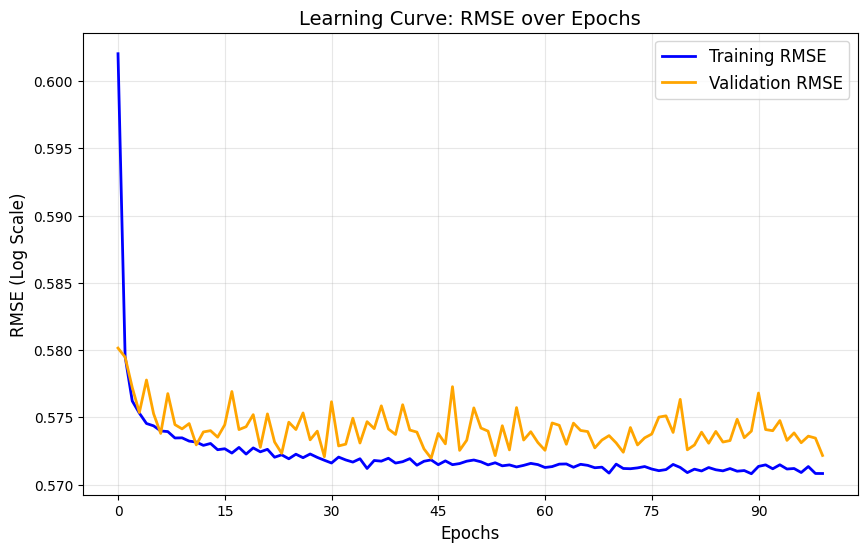

In [9]:
# 6. RMSE and Learning Curve

# Calculate Train and Validation RMSE
train_rmse_hist = np.sqrt(train_losses)
val_rmse_hist = np.sqrt(val_losses)

final_train_rmse = train_rmse_hist[-1]
final_val_rmse = val_rmse_hist[-1]

# Calculate Test RMSE
model.eval()
test_mse_accum = 0
total_batches = 0

with torch.no_grad():
    for Xb, yb in te_dl:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        out = model(Xb)

        # average MSE per pixel
        batch_mse = criterion(out, yb).item()

        test_mse_accum += batch_mse
        total_batches += 1

# Average the batch MSEs to get global MSE
global_test_mse = test_mse_accum / total_batches
final_test_rmse = np.sqrt(global_test_mse)

# Print RMSE
print(f"Train RMSE: {final_train_rmse:.4f}")
print(f"Val   RMSE: {final_val_rmse:.4f}")
print(f"Test  RMSE: {final_test_rmse:.4f}")

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_rmse_hist, label='Training RMSE', color='blue', linewidth=2)
plt.plot(val_rmse_hist, label='Validation RMSE', color='orange', linewidth=2)

plt.title('Learning Curve: RMSE over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('RMSE (Log Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

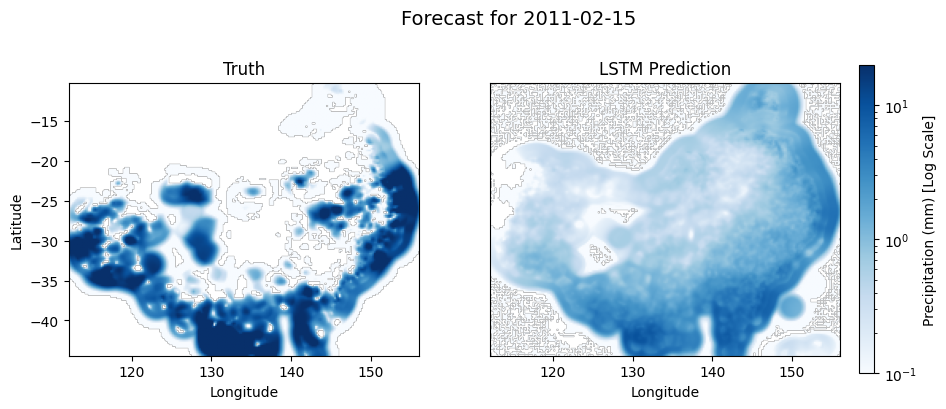

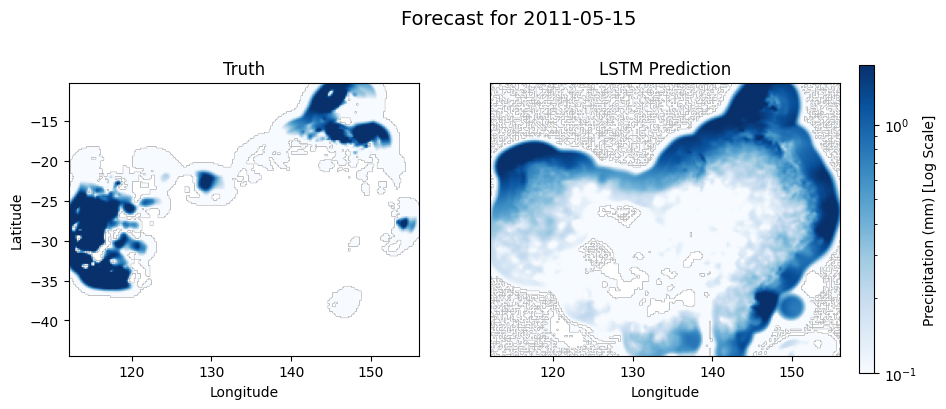

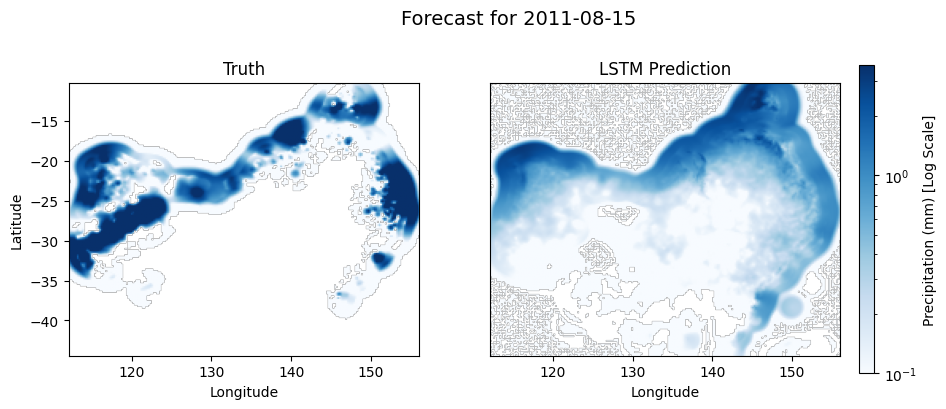

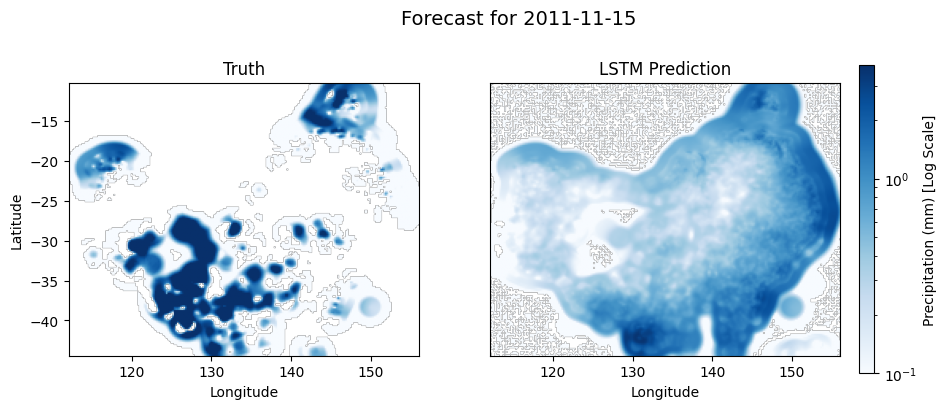

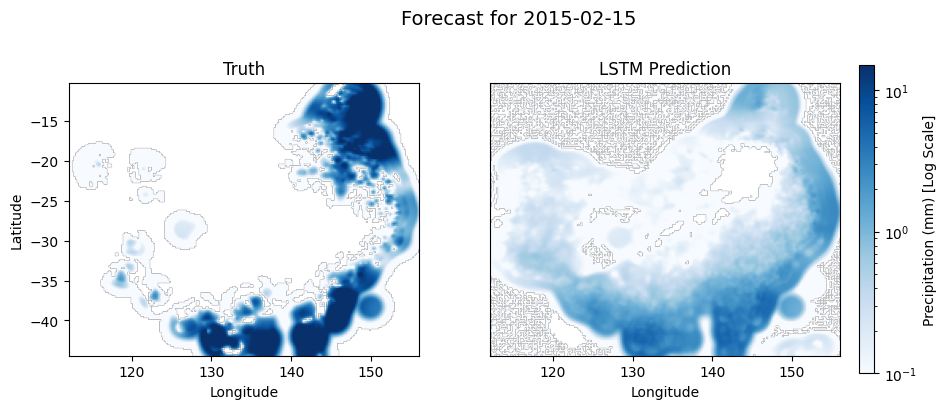

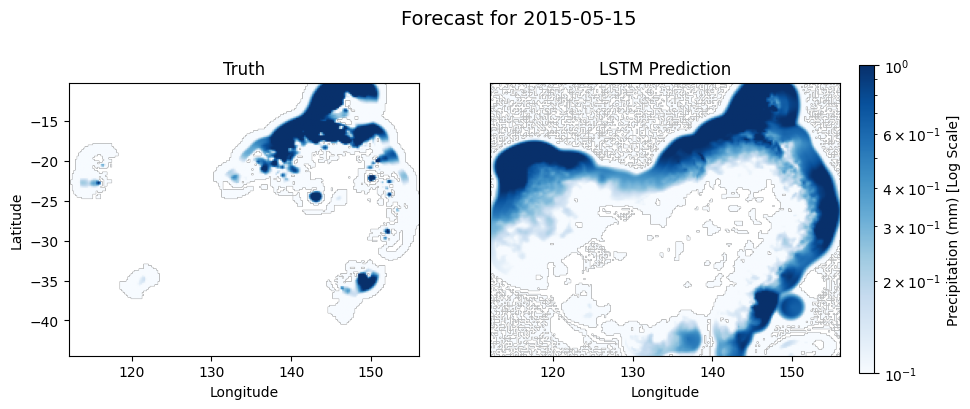

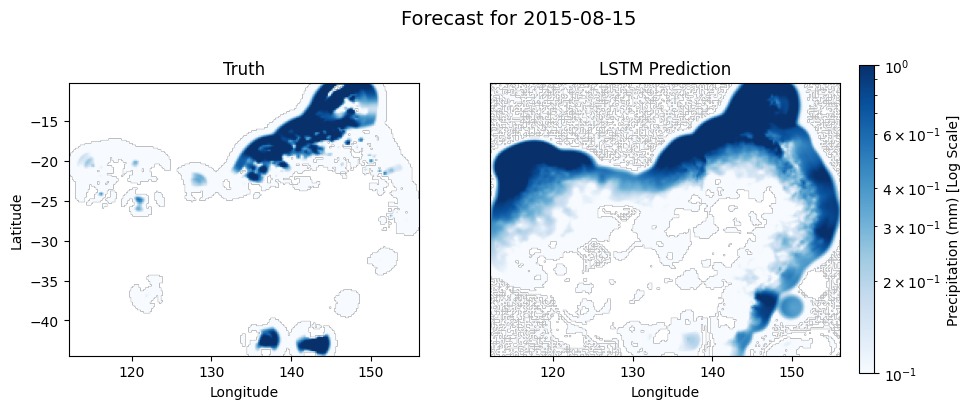

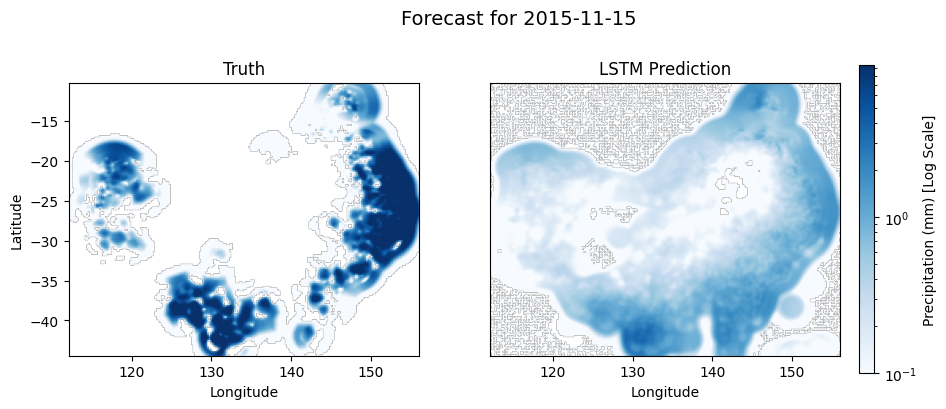

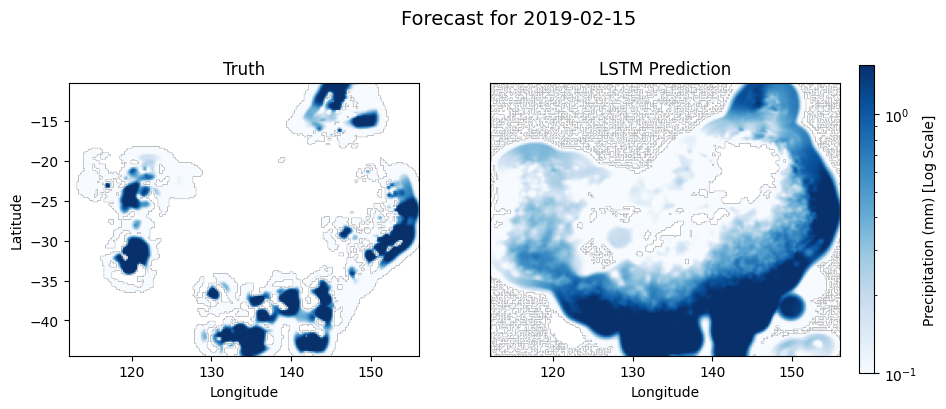

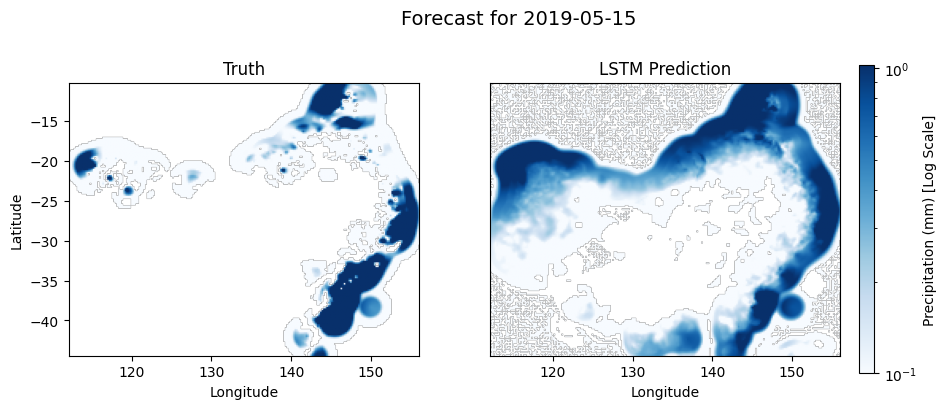

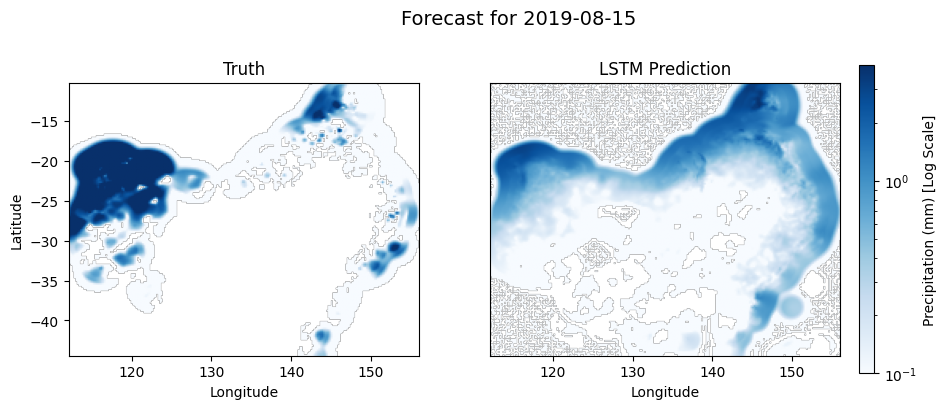

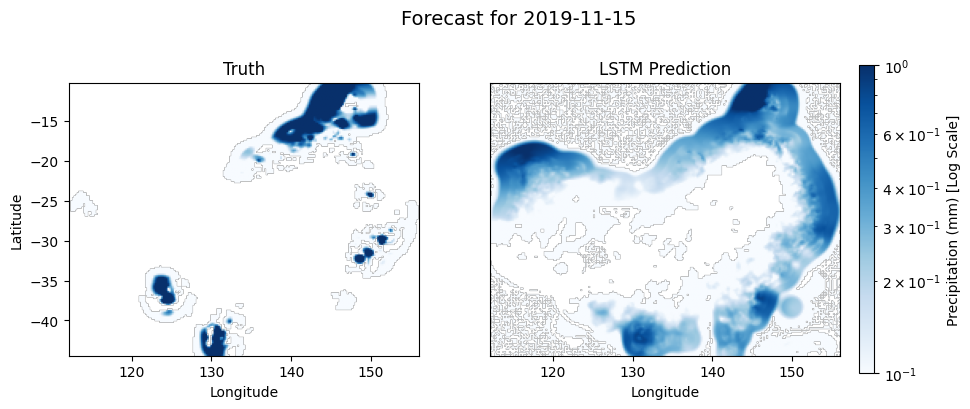

In [13]:
# 7. Plot Maps

# Define the Helper Function
def plot_comparison(date_str):
    # Find the Index
    target_date = np.datetime64(date_str)

    abs_idx = np.where(ds_te.time.values.astype('datetime64[D]') == target_date)[0][0]
    model_idx = abs_idx - T_IN

    model.eval()

    # Prepare Input
    X_input = torch.from_numpy(X_test[model_idx]).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        y_pred_flat = model(X_input).cpu().numpy()
        y_truth_flat = y_test[model_idx]

        pred_map = y_pred_flat.reshape(LAT_SIZE, LON_SIZE)
        truth_map = y_truth_flat.reshape(LAT_SIZE, LON_SIZE)

        pred_mm = y_inv(pred_map)
        truth_mm = y_inv(truth_map)

    # Plot
    vmax = np.percentile(truth_mm, 95)
    if vmax < 1:
        vmax = 1

    extent = [ds_te.lon.min(), ds_te.lon.max(), ds_te.lat.min(), ds_te.lat.max()]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Forecast for {date_str}", fontsize=14, y=1.02)

    # Plot Truth
    im1 = ax[0].imshow(truth_mm, cmap='Blues', extent=extent, norm=LogNorm(vmin=0.1, vmax=vmax))
    ax[0].set_title("Truth")
    ax[0].set_ylabel("Latitude")
    ax[0].set_xlabel("Longitude")

    # Plot Prediction
    im2 = ax[1].imshow(pred_mm, cmap='Blues', extent=extent, norm=LogNorm(vmin=0.1, vmax=vmax))
    ax[1].set_title("LSTM Prediction")
    ax[1].set_xlabel("Longitude")
    ax[1].set_yticks([])

    # Colorbar
    cbar = fig.colorbar(im2, ax=ax.ravel().tolist(), pad=0.02, label='Precipitation (mm) [Log Scale]')
    plt.show()


# date
dates_to_plot = [
    '2011-02-15', '2011-05-15', '2011-08-15', '2011-11-15',
    '2015-02-15', '2015-05-15', '2015-08-15', '2015-11-15',
    '2019-02-15', '2019-05-15', '2019-08-15', '2019-11-15'
]

for date in dates_to_plot:
    plot_comparison(date)